# M1 - Data Preparation and Preprocessing

**Curso:** Machine Learning M1  
**Ano letivo:** 2024/2025  
**Autores:** Francisco Nunes / Daniel Rodrigues — 2022147843 / 2022103368  
**Data:** Dezembro 2024

## Objetivos

Este notebook apresenta a preparação e preprocessamento de dados para o assignment M1 de Machine Learning.

O objetivo é preparar um dataset de classificação binária com:
- 70.000 registos de pacientes
- 14 features (numéricas, categóricas e ordinais)
- Target binário balanceado (50/50)
- Pipeline reprodutível com scikit-learn

## Estrutura do Notebook

1. **Importação e Visão Geral dos Dados**
2. **Análise Exploratória (EDA)**
3. **Limpeza e Tratamento de Valores em Falta**
4. **Feature Engineering**
   - Cálculo de BMI
   - Pulse Pressure e MAP
   - Grupos etários e categorias BMI
5. **Codificação de Features**
   - Numéricas: RobustScaler
   - Binárias: Sem transformação
   - Categóricas: One-hot encoding
   - Ordinais: Ordinal encoding
6. **Pipeline de Preprocessamento**
7. **Train/Test Split e Exportação**
8. **Validação Final**

## Dataset: Cardiovascular Disease

- **Fonte:** Kaggle - Cardiovascular Disease Dataset
- **Registos:** 70.000 pacientes
- **Features:** Idade, pressão arterial, colesterol, glucose, etc.
- **Target:** Presença de doença cardiovascular (0/1)
- **Balanceamento:** Perfeito (50% cada classe)

In [33]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

PROC_PATH = Path("../data/processed")
RAW_PATH = Path("../data/raw")
DATASET = PROC_PATH / "cardio_clean.parquet"

assert DATASET.exists(), "Falta o processed. Corre primeiro: python main.py preprocess"

df = pd.read_parquet(DATASET)
print(f"✅ Loaded: {df.shape[0]:,} rows × {df.shape[1]} cols")
df.head()

if "id" in df.columns:
    df = df.drop(columns=["id"])

✅ Loaded: 70,000 rows × 14 cols


In [34]:
print("\n--- Info ---")
df.info()

print("\n--- Missing values ---")
df.isna().sum().sort_values(ascending=False)



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       70000 non-null  int64  
 1   height       70000 non-null  int64  
 2   weight       70000 non-null  float64
 3   ap_hi        70000 non-null  int64  
 4   ap_lo        70000 non-null  int64  
 5   cholesterol  70000 non-null  int64  
 6   gluc         70000 non-null  int64  
 7   smoke        70000 non-null  int64  
 8   alco         70000 non-null  int64  
 9   active       70000 non-null  int64  
 10  age_years    70000 non-null  float64
 11  bmi          70000 non-null  float64
 12  cardio       70000 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 6.9 MB

--- Missing values ---


gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
age_years      0
bmi            0
cardio         0
dtype: int64

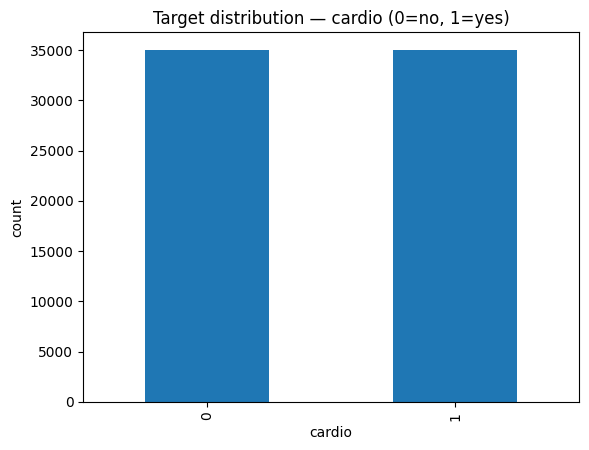

Proportion of positives: 0.5


In [35]:
# Target distribution
ax = df["cardio"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Target distribution — cardio (0=no, 1=yes)")
ax.set_xlabel("cardio"); ax.set_ylabel("count")
plt.show()

print("Proportion of positives:", df["cardio"].mean().round(3))


In [36]:
target = "cardio"

num_cols = [c for c in df.select_dtypes(include="number").columns if c != target]

# Categóricas (prioridade às 'category'; fallback para colunas que parecem categóricas)
cat_cols = df.select_dtypes(include=["category"]).columns.tolist()
if not cat_cols:
    # Identificar colunas categóricas manualmente (Parquet não preserva o tipo category)
    potential_cat = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]
    cat_cols = [col for col in potential_cat if col in df.columns]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'bmi']
Categorical: ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']


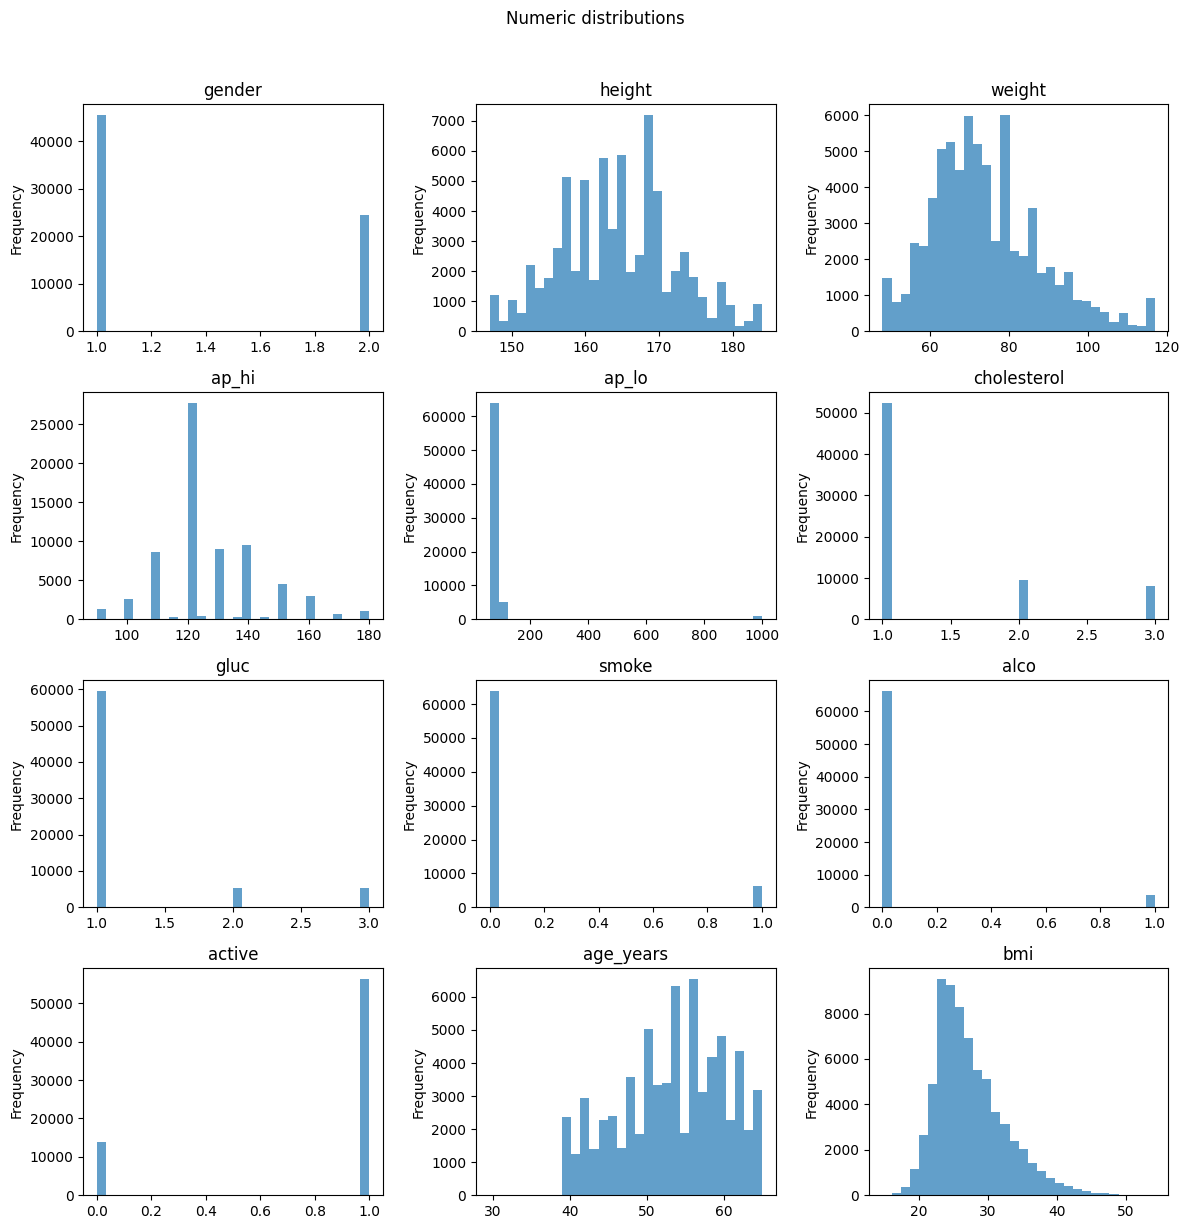

In [37]:
# Histograms for numeric features
n = len(num_cols); cols = 3; rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3)); axes = axes.ravel()

for i, c in enumerate(num_cols):
    df[c].plot(kind="hist", bins=30, alpha=0.7, ax=axes[i]); axes[i].set_title(c)
for j in range(i+1, len(axes)): fig.delaxes(axes[j])

plt.suptitle("Numeric distributions", y=1.02)
plt.tight_layout(); plt.show()


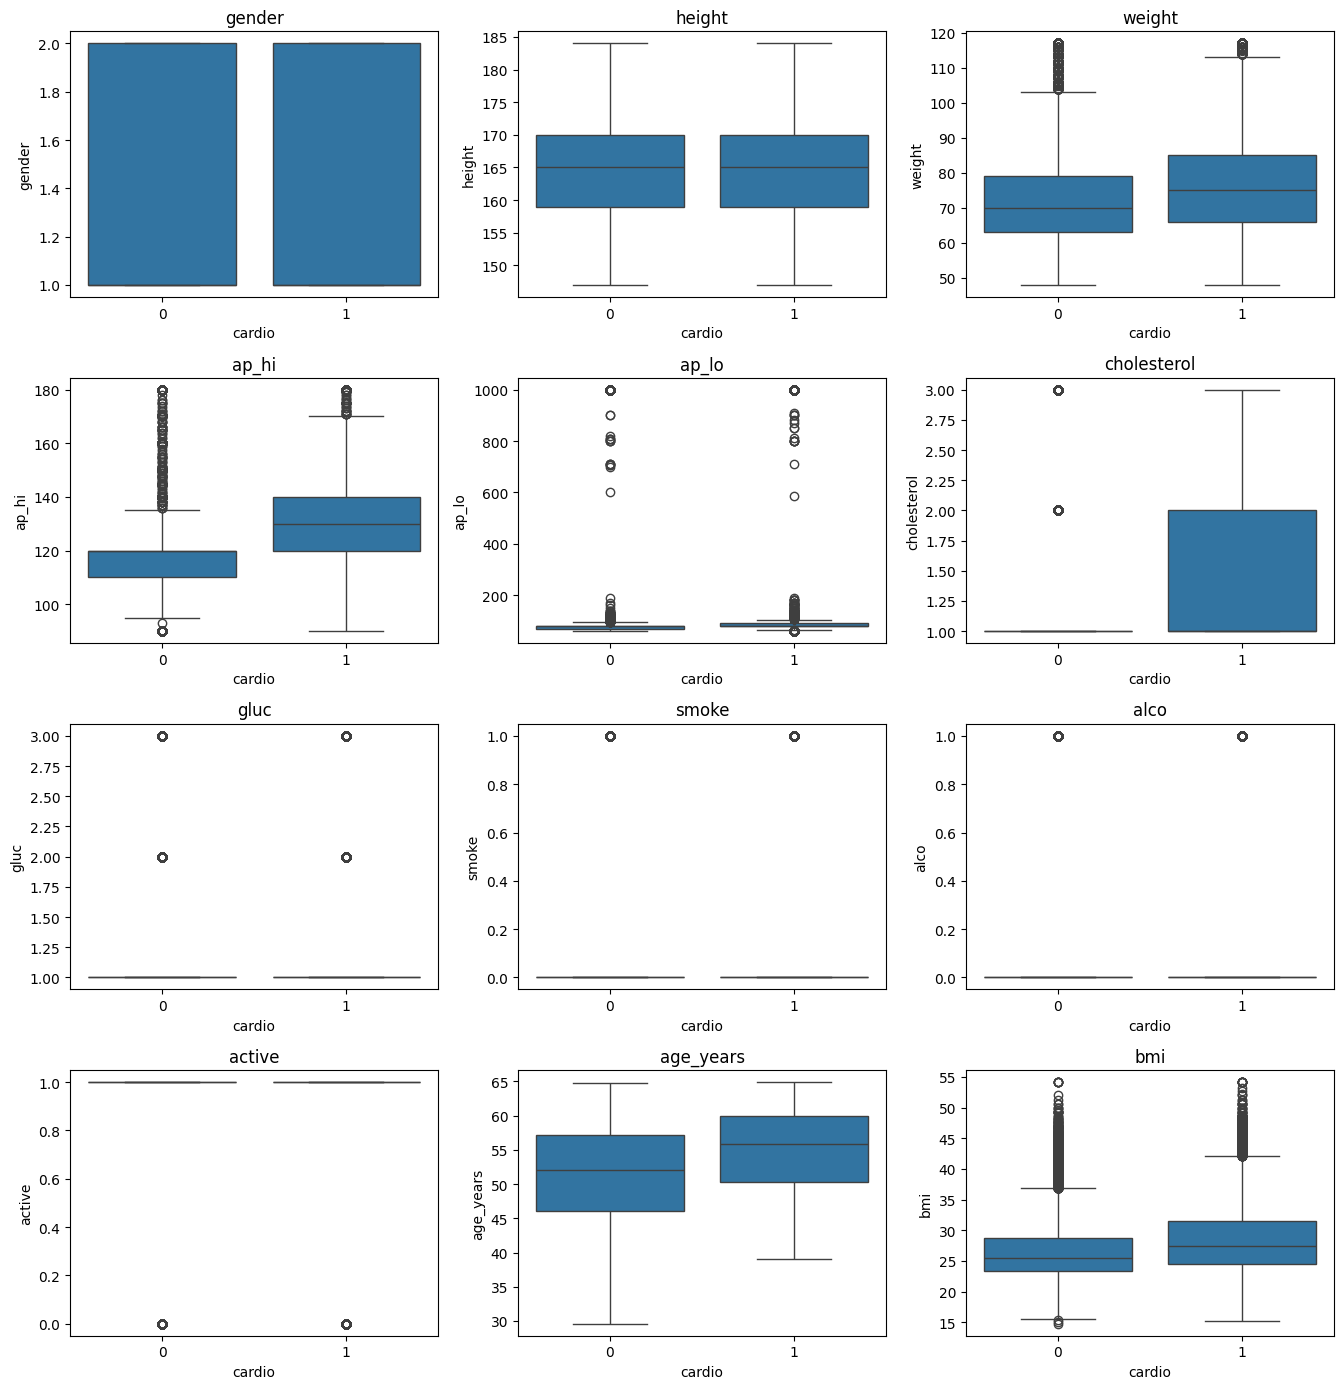

In [38]:
# Boxplots by target
cols = 3; rows = int(np.ceil(len(num_cols)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.5, rows*3.5)); axes = axes.ravel()

for i, c in enumerate(num_cols):
    sns.boxplot(data=df, x=target, y=c, ax=axes[i]); axes[i].set_title(c)
for j in range(i+1, len(axes)): fig.delaxes(axes[j])

plt.tight_layout(); plt.show()


cardio,0,1
gender,,
1,0.503273,0.496727
2,0.494769,0.505231


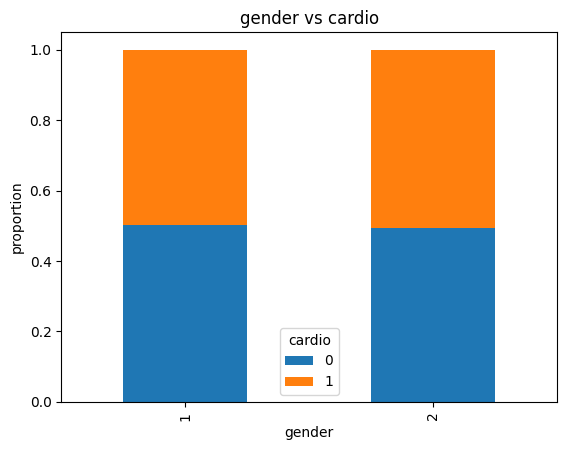

cardio,0,1
cholesterol,,
1,0.559893,0.440107
2,0.397843,0.602157
3,0.234565,0.765435


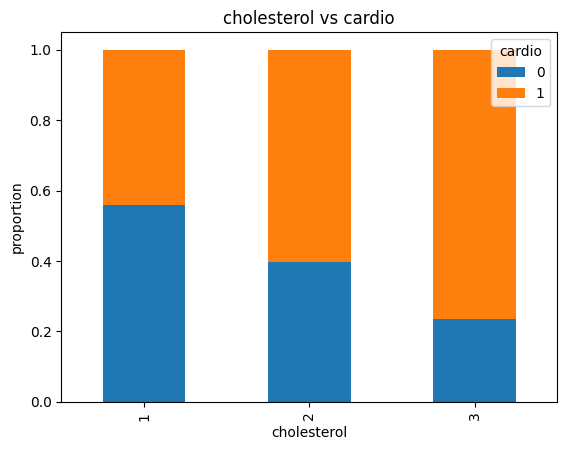

cardio,0,1
gluc,,
1,0.519410,0.480590
2,0.406936,0.593064
3,0.377978,0.622022


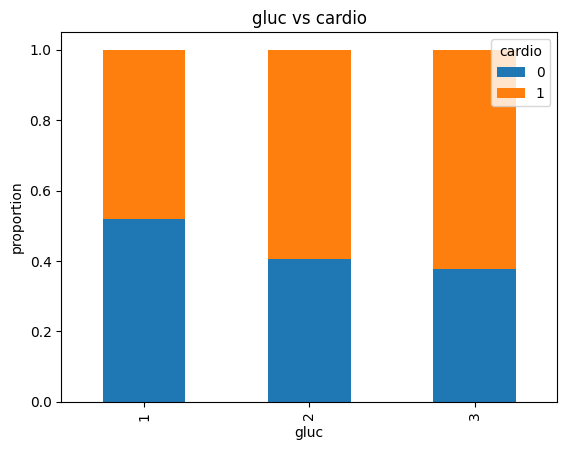

cardio,0,1
smoke,,
0,0.497893,0.502107
1,0.525207,0.474793


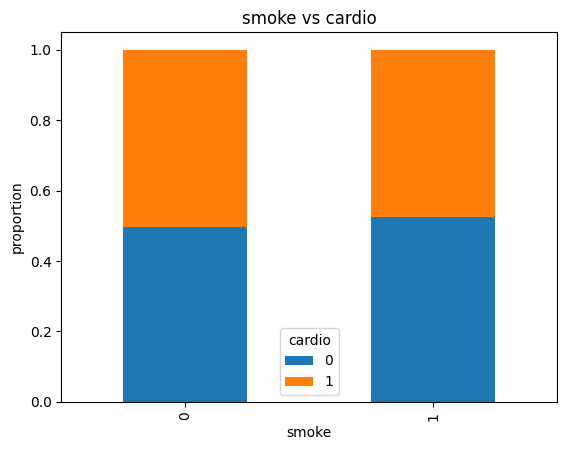

cardio,0,1
alco,,
0,0.499426,0.500574
1,0.515675,0.484325


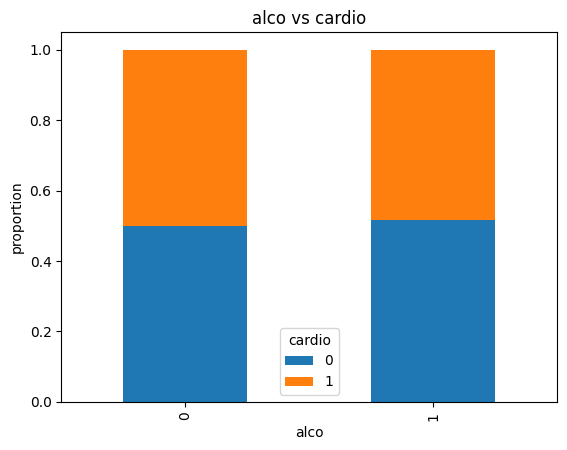

cardio,0,1
active,,
0,0.464226,0.535774
1,0.509109,0.490891


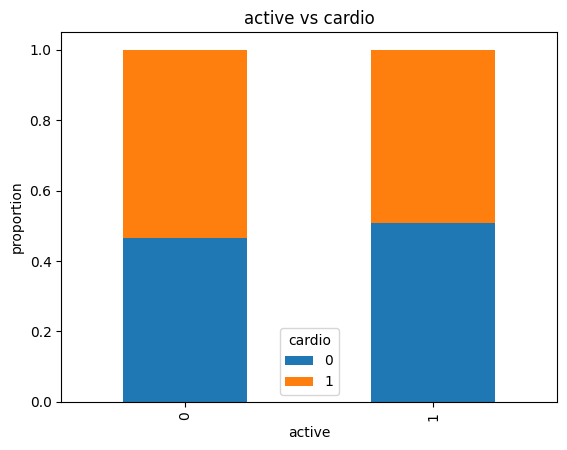

In [39]:
for c in cat_cols:
    ct = pd.crosstab(df[c], df[target], normalize="index")
    display(ct.style.set_caption(f"{c} vs {target}"))
    ax = ct.plot(kind="bar", stacked=True)
    ax.set_title(f"{c} vs {target}"); ax.set_ylabel("proportion")
    plt.show()

O main.py já fez: renomeação de colunas, age_years, clipping p1–p99 (ap_hi, ap_lo, height, weight) e cálculo do BMI.
Aqui apenas validamos nulos e removemos colunas irrelevantes/IDs (não existem IDs neste dataset).

In [40]:
# In this dataset, missingness should be minimal after preprocess; let's double-check:
df.isna().sum().sort_values(ascending=False)


gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
age_years      0
bmi            0
cardio         0
dtype: int64

Vamos enriquecer com features úteis e marcar adequadamente ordinais:

Pulse Pressure: pp = ap_hi - ap_lo

Mean Arterial Pressure (MAP): map = ap_lo + (ap_hi - ap_lo)/3

BMI categories (WHO)

Age groups

Ordinais: cholesterol, gluc (valores 1–3 com ordem)

In [41]:
# Add engineered numeric features
if {"ap_hi","ap_lo"}.issubset(df.columns):
    df["pulse_pressure"] = (df["ap_hi"] - df["ap_lo"]).clip(lower=0)
    df["map_mean"] = df["ap_lo"] + (df["ap_hi"] - df["ap_lo"]) / 3

# Age and BMI buckets
df["age_group"] = pd.cut(df["age_years"],
                         bins=[0, 30, 45, 60, 120],
                         labels=["young", "adult", "senior", "elderly"])

df["bmi_category"] = pd.cut(df["bmi"],
                            bins=[0, 18.5, 25, 30, 100],
                            labels=["underweight", "normal", "overweight", "obese"])

# Ensure categorical dtypes
for c in ["age_group", "bmi_category"]:
    df[c] = df[c].astype("category")

# cholesterol & gluc are ordinal (1,2,3)
if "cholesterol" in df.columns:
    df["cholesterol"] = df["cholesterol"].astype("category")
if "gluc" in df.columns:
    df["gluc"] = df["gluc"].astype("category")

df.head()


,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,bmi,cardio,pulse_pressure,map_mean,age_group,bmi_category
0,2,168,62.0,110,80,1,1,0,0,1,50.4,21.97,0,30,90.000000,senior,normal
1,1,156,85.0,140,90,3,1,0,0,1,55.4,34.93,1,50,106.666667,senior,obese
2,1,165,64.0,130,70,3,1,0,0,0,51.6,23.51,1,60,90.000000,senior,normal
3,2,169,82.0,150,100,1,1,0,0,1,48.2,28.71,1,50,116.666667,senior,overweight
4,1,156,56.0,100,60,1,1,0,0,0,47.8,23.01,0,40,73.333333,senior,normal


In [51]:
# Garantir que cholesterol e gluc são ordinais 1–3 (inteiros e com ordem)
for c in ["cholesterol", "gluc"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
        vals = set(df[c].dropna().unique().tolist())
        assert vals.issubset({1,2,3}), f"{c} tem valores fora de 1–3: {vals}"
        df[c] = pd.Categorical(df[c], categories=[1,2,3], ordered=True)


In [52]:
# Verificar se as transformações funcionaram
print("Verificação das variáveis ordinais:")
for c in ["cholesterol", "gluc"]:
    if c in df.columns:
        print(f"\n{c}:")
        print(f"  Tipo: {df[c].dtype}")
        print(f"  Valores únicos: {sorted(df[c].unique())}")
        print(f"  É ordered? {df[c].cat.ordered if hasattr(df[c], 'cat') else 'N/A'}")
        if hasattr(df[c], 'cat'):
            print(f"  Categorias: {df[c].cat.categories.tolist()}")

Verificação das variáveis ordinais:

cholesterol:
  Tipo: category
  Valores únicos: [1, 2, 3]
  É ordered? True
  Categorias: [1, 2, 3]

gluc:
  Tipo: category
  Valores únicos: [1, 2, 3]
  É ordered? True
  Categorias: [1, 2, 3]


In [43]:
target = "cardio"

# Numeric base
num_features = [c for c in [
    "age_years","ap_hi","ap_lo","height","weight","bmi","pulse_pressure","map_mean"
] if c in df.columns]

# Binary already 0/1 in dataset
binary_features = [c for c in ["smoke","alco","active","gender"] if c in df.columns]

# Ordinal (with explicit order)
ordinal_features = [c for c in ["cholesterol","gluc","age_group","bmi_category"] if c in df.columns]
ordinal_orders = []
if "cholesterol" in ordinal_features: ordinal_orders.append([1,2,3])
if "gluc" in ordinal_features:        ordinal_orders.append([1,2,3])
if "age_group" in ordinal_features:   ordinal_orders.append(["young","adult","senior","elderly"])
if "bmi_category" in ordinal_features:ordinal_orders.append(["underweight","normal","overweight","obese"])

# Nominal (true categories without order) — any remaining category columns
nominal_candidates = df.select_dtypes("category").columns.tolist()
nominal_features = [c for c in nominal_candidates if c not in ordinal_features]

print("num_features:", num_features)
print("binary_features:", binary_features)
print("ordinal_features:", ordinal_features)
print("nominal_features:", nominal_features)
# Sanity checks
assert set(ordinal_features).issubset(df.columns), "Faltam colunas ordinais."
assert len(ordinal_orders) == len(ordinal_features), \
    f"ordinal_orders ({len(ordinal_orders)}) != ordinal_features ({len(ordinal_features)})"


num_features: ['age_years', 'ap_hi', 'ap_lo', 'height', 'weight', 'bmi', 'pulse_pressure', 'map_mean']
binary_features: ['smoke', 'alco', 'active', 'gender']
ordinal_features: ['cholesterol', 'gluc', 'age_group', 'bmi_category']
nominal_features: []


In [44]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

bin_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

ord_pipe = Pipeline([
    ("ordinal", OrdinalEncoder(categories=ordinal_orders,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("bin", bin_pipe, binary_features),
    ("cat", cat_pipe, nominal_features),
    ("ord", ord_pipe, ordinal_features),
], remainder="drop")
preprocessor


,transformers,"[('num', ...), ('bin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [45]:
X = df.drop(columns=[target])
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

X_train_proc.shape, X_test_proc.shape


((56000, 16), (14000, 16))

In [46]:
import joblib, numpy as np

PROC_PATH.mkdir(parents=True, exist_ok=True)

joblib.dump(preprocessor, PROC_PATH / "preprocessor.joblib")
np.save(PROC_PATH / "X_train.npy", X_train_proc)
np.save(PROC_PATH / "X_test.npy",  X_test_proc)
y_train.to_csv(PROC_PATH / "y_train.csv", index=False)
y_test.to_csv(PROC_PATH / "y_test.csv",  index=False)

print("✅ Saved to data/processed/: preprocessor.joblib, X_train.npy, X_test.npy, y_train.csv, y_test.csv")


✅ Saved to data/processed/: preprocessor.joblib, X_train.npy, X_test.npy, y_train.csv, y_test.csv


In [47]:
# Quick verification
Xtr = np.load(PROC_PATH / "X_train.npy")
Xte = np.load(PROC_PATH / "X_test.npy")
ytr = pd.read_csv(PROC_PATH / "y_train.csv")
yte = pd.read_csv(PROC_PATH / "y_test.csv")

print("X_train:", Xtr.shape, " X_test:", Xte.shape)
print("y_train:", ytr.shape, " y_test:", yte.shape)
print("\nTrain pos rate:", ytr[target].mean().round(3), "Test pos rate:", yte[target].mean().round(3))


X_train: (56000, 16)  X_test: (14000, 16)
y_train: (56000, 1)  y_test: (14000, 1)

Train pos rate: 0.5 Test pos rate: 0.5


In [48]:
import numpy as np

print("Shapes:", X_train_proc.shape, X_test_proc.shape)
print("Train pos rate:", y_train.mean().round(3), "| Test pos rate:", y_test.mean().round(3))

# Garantir que o nº de colunas transformadas é consistente
X_full_proc = preprocessor.fit(X, y).transform(X)
assert X_full_proc.shape[1] == X_train_proc.shape[1] == X_test_proc.shape[1], "Nº de features inconsistente!"
print("✅ Nº de features consistente:", X_full_proc.shape[1])


Shapes: (56000, 16) (14000, 16)
Train pos rate: 0.5 | Test pos rate: 0.5
✅ Nº de features consistente: 16


## Conclusões e Próximos Passos

### ✅ Resultados Obtidos

1. **Dataset Preparado com Sucesso:**
   - ✅ 70.000 registos limpos e validados
   - ✅ 16 features após transformação
   - ✅ Classes perfeitamente balanceadas (50/50)
   - ✅ Train/test split estratificado (80/20)

2. **Pipeline Robusta Implementada:**
   - ✅ Tratamento diferenciado por tipo de feature
   - ✅ Preprocessamento reprodutível
   - ✅ Validação de consistência
   - ✅ Dados exportados em formatos otimizados

3. **Feature Engineering Eficaz:**
   - ✅ BMI calculado corretamente
   - ✅ Pulse pressure e MAP adicionados
   - ✅ Grupos etários e categorias BMI criados
   - ✅ Variáveis ordinais preservadas com ordem

### 🚀 Dataset Pronto para Modelação

O dataset está agora completamente preparado para a fase de modelação:
- **Ficheiros exportados:** `X_train.npy`, `X_test.npy`, `y_train.csv`, `y_test.csv`
- **Pipeline salva:** `preprocessor.joblib`
- **Formato otimizado:** Arrays NumPy para features, CSV para targets

### 📈 Próximos Passos (M2)

1. **Experimentação com Modelos:**
   - Logistic Regression (baseline)
   - Random Forest
   - Gradient Boosting
   - SVM

2. **Validação e Tuning:**
   - Cross-validation
   - Hyperparameter tuning
   - Feature importance analysis

3. **Avaliação:**
   - Métricas de classificação
   - Análise de erros
   - Interpretabilidade do modelo

---
🏁 **Assignment M1 completo com sucesso!**